In [49]:
# Package Imports
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib
import matplotlib.pyplot as plt

import hvplot.pandas
import cartopy
import geoviews

from shapely.geometry import MultiLineString, LineString, Polygon, Point
from shapely import wkt
from shapely.affinity import rotate, scale

import rasterio
import rasterio.features
import rasterio.warp
from rasterio.plot import show

from imp import reload

# Importing my modules
import data_loading, set_cover, plotting, geometry_operations

##### Reading the TIF and CSV Data

In [50]:
forest_area_gpd = gpd.GeoDataFrame(pd.DataFrame(
    {"name": ["area1", "area2", "area3", "area4", "area5"]}), 
    geometry=data_loading.read_tif("Resources_Organized/tif/Bestand3.tif"))
#forest_area_gpd.plot()

#load the data and show that we have correctly parsed the CSV
bestand_3_csv = data_loading.read_csv("Resources_Organized/csv/Bestand3_h.csv")
bestand_3_csv = data_loading.format_csv(bestand_3_csv)
bestand_3_csv.head

<bound method NDFrame.head of              x          y       z     id          BHD      h crownLength  \
0   -68.216701  61.395624 -52.341    1.0  56,14971429  38,74       37,64   
1   -42.198416  22.294888 -26.887    2.0            4   9,54           0   
2   -35.660549  48.789428 -39.520    3.0   34,5655619  33,07       15,77   
3   -63.811228  60.685099 -52.156    4.0      32,0572  33,07       10,92   
4   -12.395044  77.242318 -42.336    5.0  38,38882324  24,77           0   
..         ...        ...     ...    ...          ...    ...         ...   
628   4.503100  96.760800 -52.333  640.0         63,8  20,51           0   
629   3.241200  92.597600 -48.579  641.0           10  28,74           0   
630  11.452980  27.791890  -9.873  642.0        44,56   31,1        25,9   
631  10.763840  30.705970 -11.548  643.0        28,66  24,77           0   
632   9.759666  89.327680 -42.205  647.0           10  29,32           0   

    crownArea crownVolume crownDiameter  
0        34,8  

#### Adding trees to the map

<AxesSubplot:xlabel='X coordinate', ylabel='Y coordinate'>

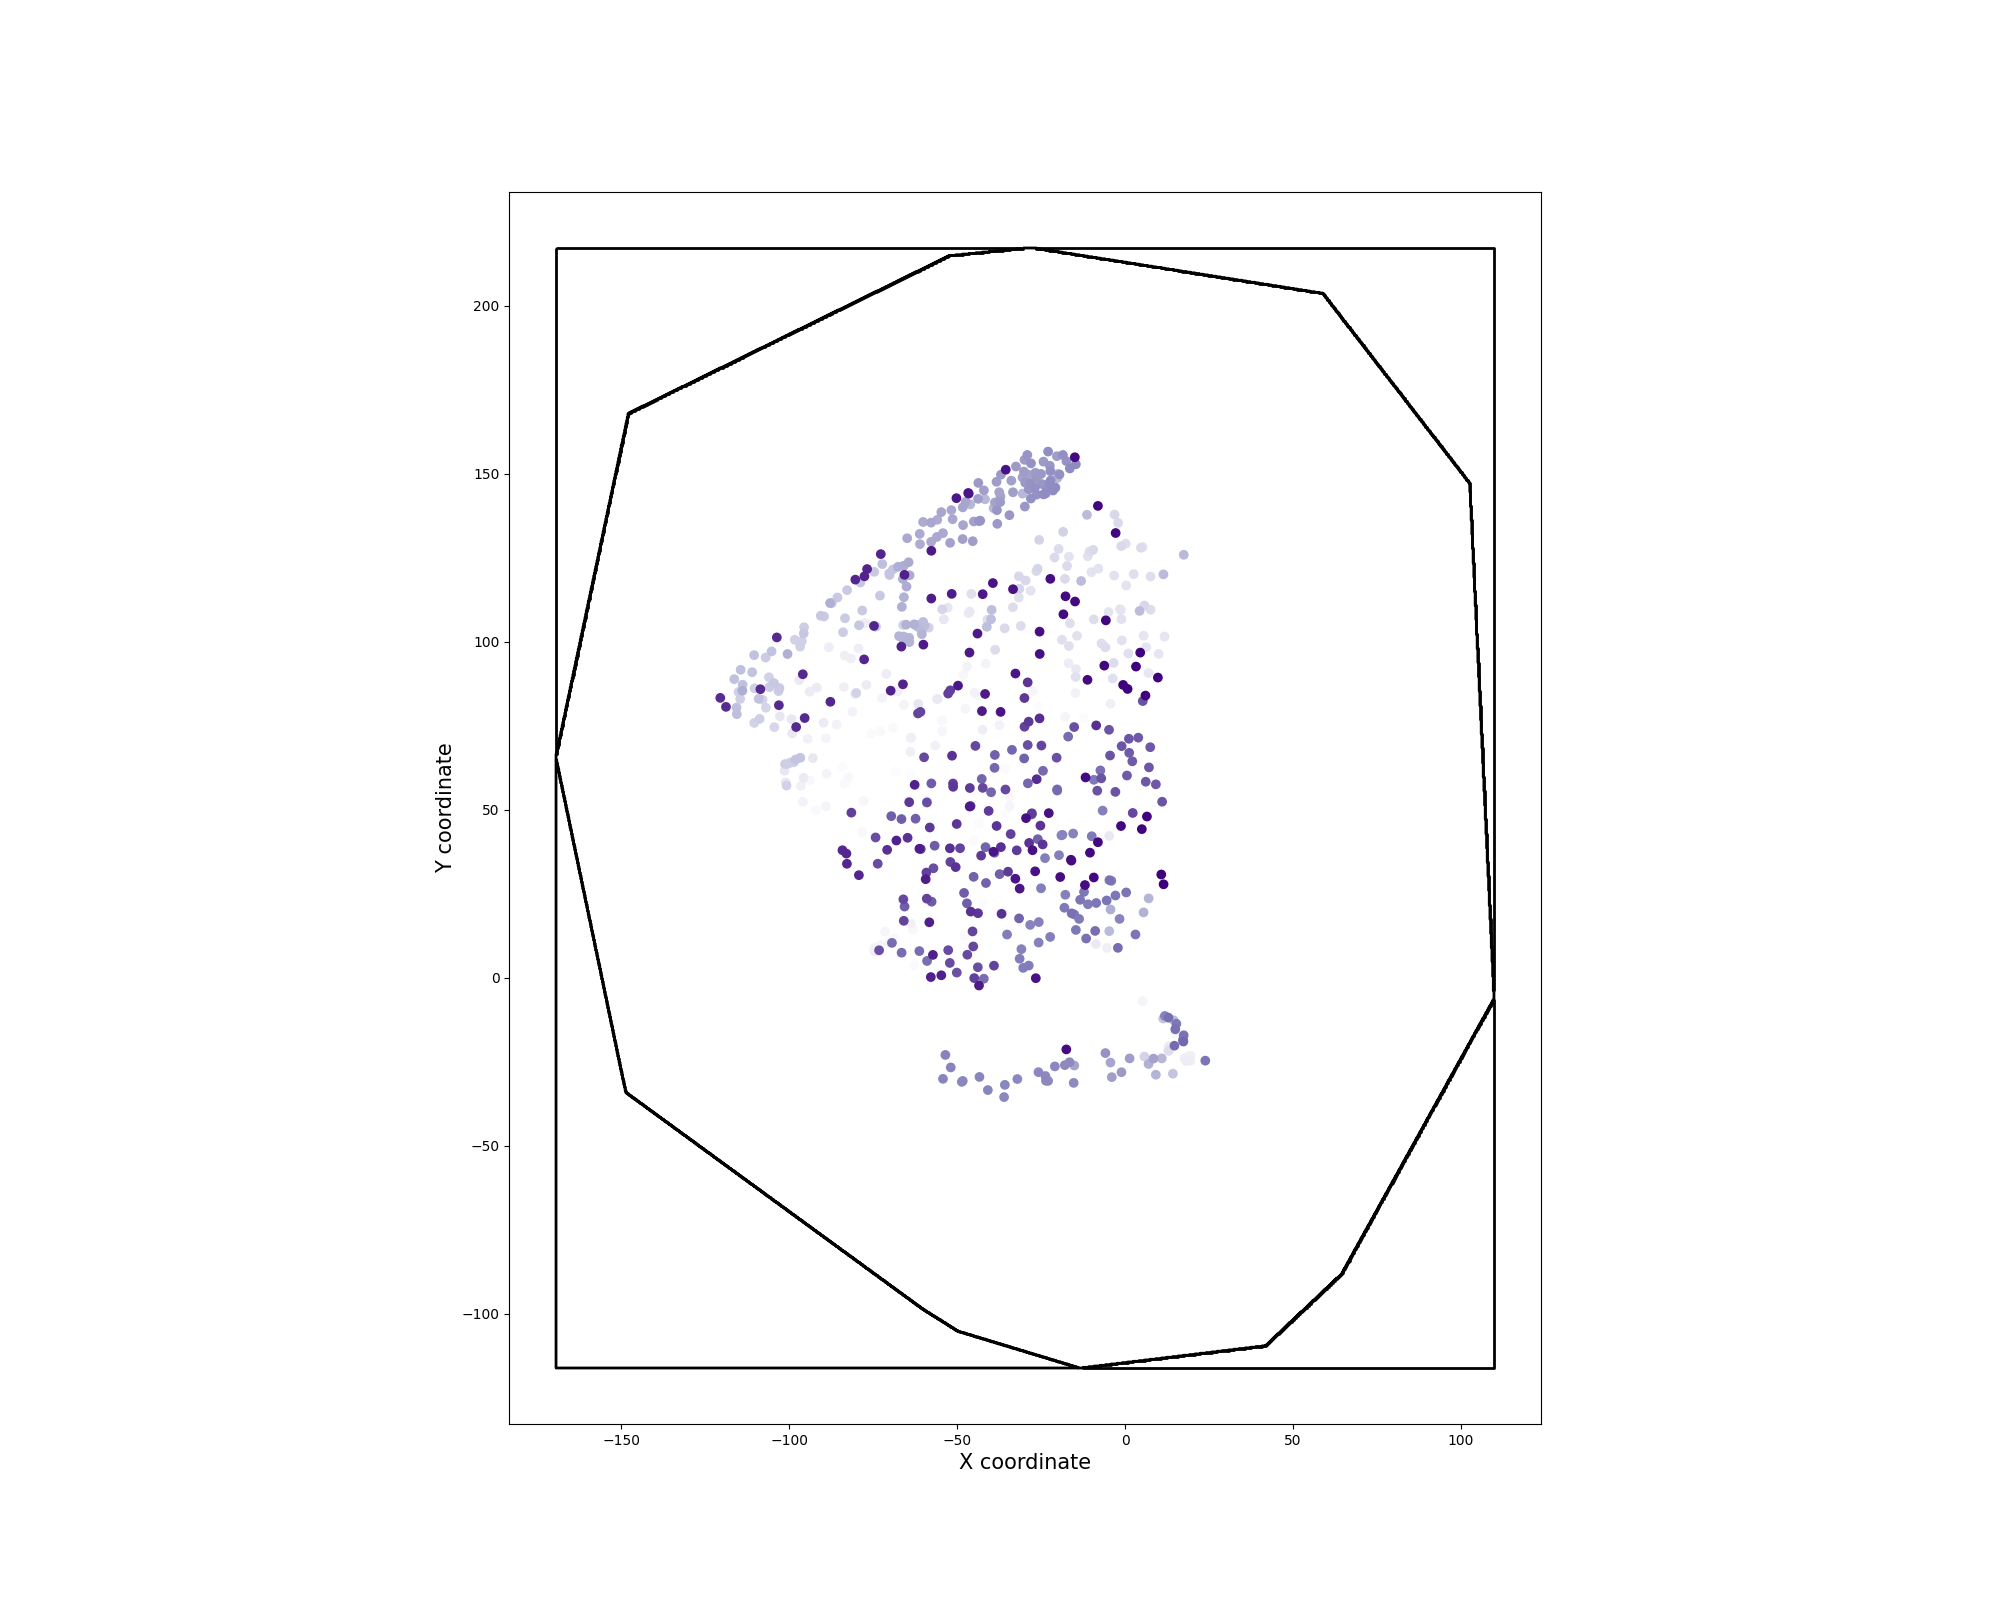

In [51]:
point_list = [Point(xy) for xy in zip(bestand_3_csv["x"], bestand_3_csv["y"])]
tree_gpd = gpd.GeoDataFrame(data=bestand_3_csv,geometry=point_list)

#verify that the boundary and trees add up
fig, ax = plt.subplots(figsize = (20,16))
ax.set_xlabel('X coordinate', fontsize=15)
ax.set_ylabel('Y coordinate', fontsize=15)
tree_gpd.plot(cmap = 'Purples',ax=ax)
forest_area_gpd.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 2,ax=ax)

In [8]:
#interactive plotting
tree_gpd.hvplot(global_extent=False, frame_height=450, frame_width=800, tiles=True)

NameError: name 'tree_gpd' is not defined

#### Joining and Overlaying Anchor Areas and Road on the Map

Recording coordinates with interactive figure

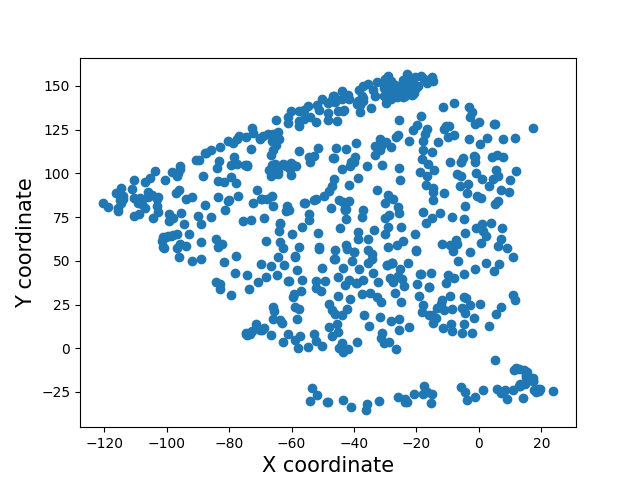

Coordinates recorded are: [(-72.65172216841935, 141.38949916445839), (-71.37094806587096, -2.159618652119036), (-20.139983963935492, -13.597795370571419), (-126.7644280010887, 84.77052440811909), (-68.80939986077419, 133.95468429746433), (-24.622693322854843, 163.12203492951792)]
Array reset
Coordinates recorded are: [(-124.52307332162903, 89.34579509550002), (-70.41036748895968, 132.8108666256191), (-27.504435053588708, 161.40630842175005), (-6.691855887177411, 150.54004053922029), (-60.48436819420968, 116.22551038386314), (-115.23746107815322, 68.75707700228574)]
Array reset


In [91]:
reload(plotting)

fig, ax = plt.subplots()
ax.set_xlabel('X coordinate', fontsize=15)
ax.set_ylabel('Y coordinate', fontsize=15)
ax.scatter(tree_gpd["x"],tree_gpd["y"])

cid = fig.canvas.mpl_connect('button_press_event', plotting.onclick)

Create the extra_geometry_gpd from manual coordinates

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


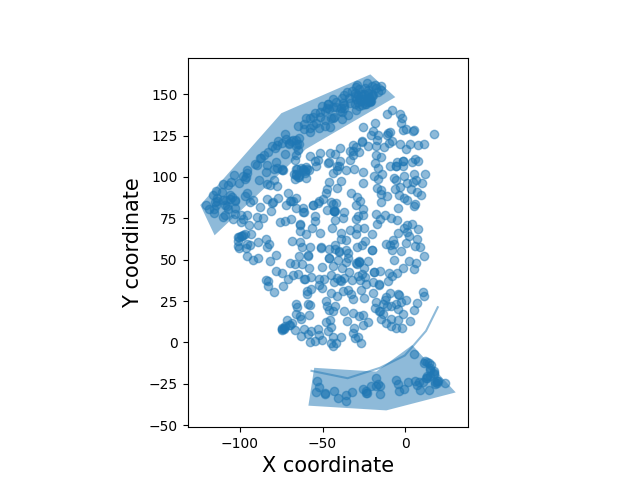

In [84]:
# manually insert those coordinates
# recorded coordinates for the given areas
uphill_anchors = Polygon([Point(xy) for xy in [(-123.88268627035482, 83.05479790035122), (-74.89307684787903, 138.5299549848453), (-21.10056454084676, 161.97821725767267), (-6.051468835903222, 148.2524051955298), (-60.16417466857257, 116.79741921978575), (-115.23746107815322, 64.75371515082742)]])
downhill_anchors = Polygon([Point(xy) for xy in [(-55.04107825837903, -15.31352187833928), (-17.578435758838708, -17.601157222029755), (4.194723984483858, -1.5877098161964227), (30.450593086725803, -30.18315161232738), (-11.49475877173387, -41.04941949485714), (-58.5632070403871, -38.189875315244045)]])
road = LineString([(-57.282432937838706, -17.029248386107135), (-34.86888614324194, -21.604519073488092), (-15.337081079379033, -15.31352187833928), (-0.2879853744354932, -7.878707011345227), (12.51975565104837, 6.990922722642864), (19.884206740701615, 21.86055245663097)])

extra_geometry_gpd = gpd.GeoDataFrame(pd.DataFrame({"name":["uphill_anchors","road","downhill_anchors"],"geometry":[uphill_anchors,road,downhill_anchors]}))
plotting.plot_gdfs([tree_gpd,extra_geometry_gpd])

#### Generating Eligible Trees and Road Pathway

In [13]:
# set the name as index to easily select 
extra_geometry_gpd.set_index("name", inplace = True)
extra_geometry_gpd.loc['road']

geometry    LINESTRING (-60.00000 -15.00000, -18.00000 -15...
Name: road, dtype: geometry

Getting the points along the road

/tmp/ipykernel_46621/1618327170.py:5: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  road_points = [road_geometry.interpolate(distance) for distance in distances] + [road_geometry.boundary[1]]


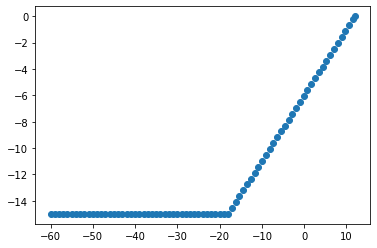

In [16]:
# thanks to https://stackoverflow.com/questions/62990029/how-to-get-equally-spaced-points-on-a-line-in-shapely
road_geometry = extra_geometry_gpd.loc['road'].geometry
distance_delta = 1
distances = np.arange(0, road_geometry.length, distance_delta)
road_points = [road_geometry.interpolate(distance) for distance in distances] + [road_geometry.boundary[1]]

plotting.plot_scatter_xy(road_points)

Getting the trees contained in the anchor/target tree polygons

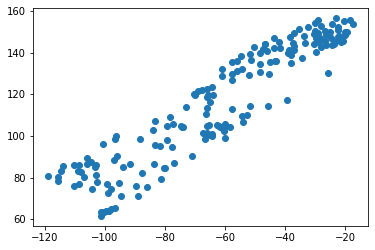

In [17]:
# get the eligible anchor and target trees inside the polygon
uphill_anchor_trees = geometry_operations.get_contained_elements(tree_gpd,extra_geometry_gpd.loc["uphill_anchors"].geometry)
downhill_anchor_trees = geometry_operations.get_contained_elements(tree_gpd,extra_geometry_gpd.loc["downhill_anchors"].geometry)

# and check if the anchor trees look good
plotting.plot_scatter_xy(downhill_anchor_trees)

#### Generating Possible Lines

Setting and rotating the slope line

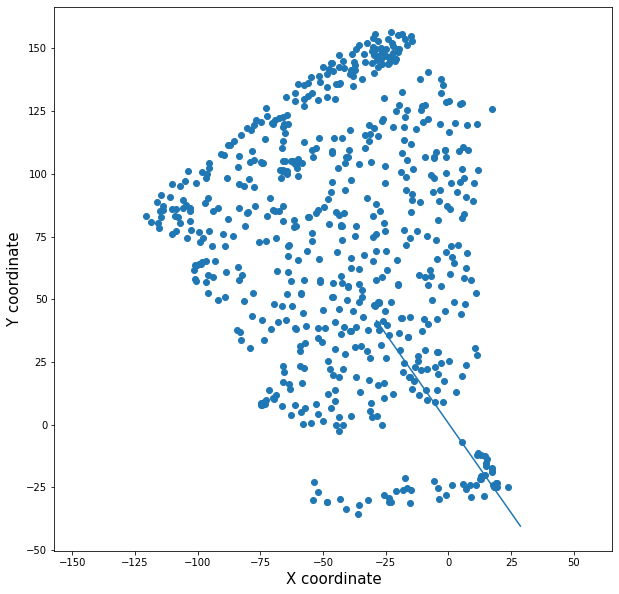

In [68]:
slope_degree = 35
# set a orientation line we can plan the line deviation around
slope_line = LineString([(0,0),(0,1)])
slope_line = rotate(slope_line, slope_degree)

# scale the line by a factor of 100 and plot it
slope_line = scale(slope_line,100,100)

ax = plotting.plot_equal_axis(slope_line)
ax.scatter(bestand_3_csv["x"], bestand_3_csv["y"])

Generating the possible lines depending on the slope

we have n lines:  7011


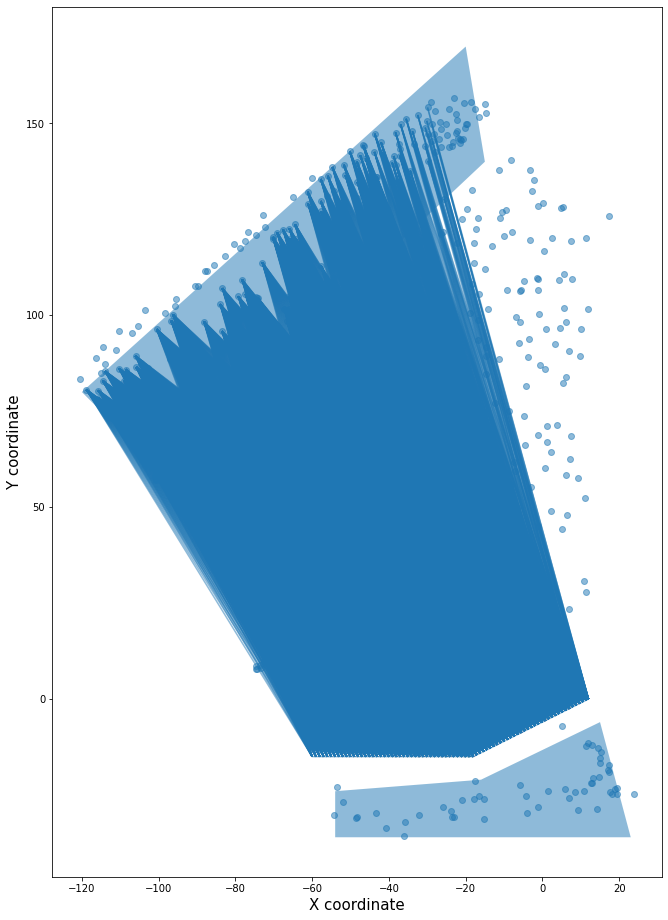

In [58]:
max_deviation = 20
possible_lines = geometry_operations.generate_possible_lines(road_points,downhill_anchor_trees,slope_line, max_deviation)
print("we have n lines: ",len(possible_lines))

line_gdf = gpd.GeoDataFrame(geometry=possible_lines)
plotting.plot_gdfs([tree_gpd,extra_geometry_gpd,line_gdf])

Compute the trees covered by each line

In [61]:
line_gdf["amount_trees_covered","number_trees_covered"] = ""
buffer_size = 5

# first version - 24.3s
reload(geometry_operations)
# vectorized version - 19.4s

coverage_series = geometry_operations.compute_points_covered_per_row(
    tree_gpd, line_gdf, buffer_size)

# and unzip the results
x,y = zip(*coverage_series)
line_gdf["id_trees_covered"] = list(x)
line_gdf["amount_trees_covered"] = list(y)

In [62]:
line_gdf["id_trees_covered"].head

<bound method NDFrame.head of 0       {512.0, 6.0, 13.0, 19.0, 21.0, 23.0, 28.0, 33....
1       {512.0, 6.0, 13.0, 19.0, 21.0, 23.0, 536.0, 28...
2       {512.0, 13.0, 18.0, 21.0, 28.0, 36.0, 37.0, 55...
3       {512.0, 6.0, 13.0, 19.0, 21.0, 23.0, 28.0, 33....
4       {512.0, 6.0, 13.0, 19.0, 21.0, 23.0, 28.0, 33....
                              ...                        
7006    {257.0, 388.0, 263.0, 9.0, 399.0, 400.0, 529.0...
7007    {257.0, 388.0, 135.0, 263.0, 9.0, 399.0, 400.0...
7008    {257.0, 388.0, 135.0, 263.0, 9.0, 399.0, 400.0...
7009    {257.0, 388.0, 263.0, 9.0, 399.0, 400.0, 529.0...
7010    {257.0, 388.0, 5.0, 133.0, 134.0, 263.0, 141.0...
Name: id_trees_covered, Length: 7011, dtype: object>

#### Set Covering Problem

Find the (one) optimal configuration of subsets covering the widest area of the forest

152  trees have not been covered


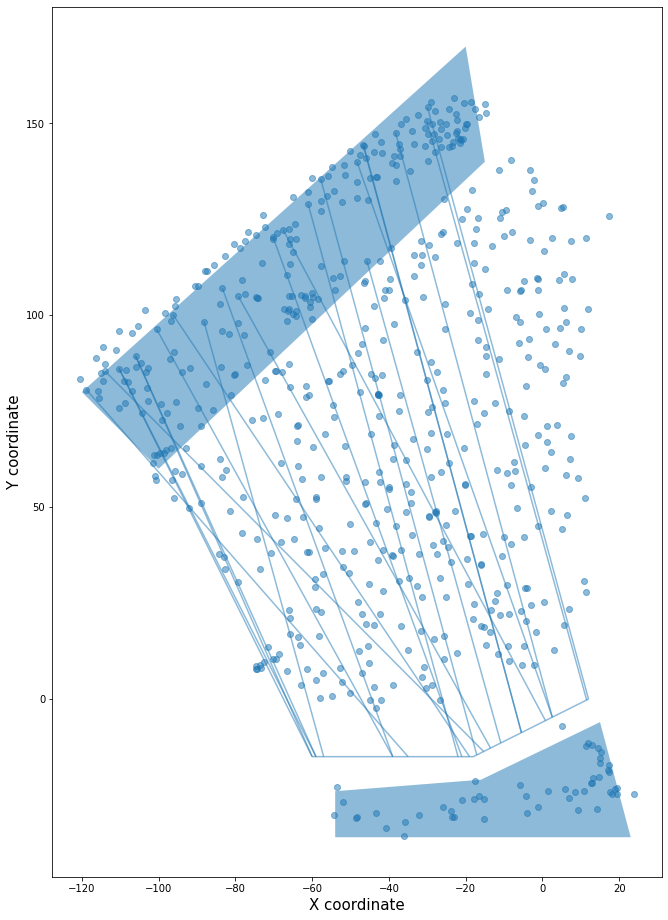

In [63]:
trees_covered_by_line_set = [set(x) for x in line_gdf["id_trees_covered"]]
covered_set = set_cover.set_cover(set(tree_gpd["id"]),trees_covered_by_line_set)
# find the corresponding lines in the df and filter the df by that
covered_lines_gdf = line_gdf[line_gdf["id_trees_covered"].isin(covered_set)]

# and plot it
plotting.plot_gdfs([tree_gpd,extra_geometry_gpd,covered_lines_gdf])

#### Adding true Optimization

Playing around with a toy example to test an optimization of the buffer area around each cable road

In [6]:
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt

# x[0] is the distance from the center line (-5, since we consider this offset without penalty)
def eggholder(x):
    return (x[0]**2)

bounds = [(-512, 512), (-512, 512)]

# plotting the function
# x = np.arange(-512, 513)
# y = np.arange(-512, 513)
# xgrid, ygrid = np.meshgrid(x, y)
# xy = np.stack([xgrid, ygrid])
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.view_init(45, -45)
# ax.plot_surface(xgrid, ygrid, eggholder(xy), cmap='terrain')
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('eggholder(x, y)')
# plt.show()

results = dict()
results['shgo'] = optimize.shgo(eggholder, bounds)
# sobol method shows a list of possible minimal solutions
results['shgo_sobol'] = optimize.shgo(eggholder, bounds, n=200, iters=5,
                                      sampling_method='sobol')

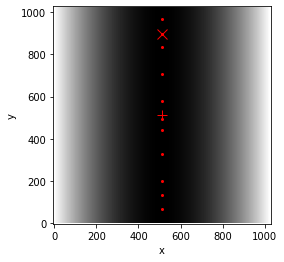

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(eggholder(xy), interpolation='bilinear', origin='lower',
               cmap='gray')
ax.set_xlabel('x')
ax.set_ylabel('y')

def plot_point(res, marker='o', color=None):
    ax.plot(512+res.x[0], 512+res.x[1], marker=marker, color=color, ms=10)

# plot_point(results['BH'], color='y')  # basinhopping           - yellow
# plot_point(results['DE'], color='c')  # differential_evolution - cyan
# plot_point(results['DA'], color='w')  # dual_annealing.        - white

# SHGO produces multiple minima, plot them all (with a smaller marker size)
plot_point(results['shgo'], color='r', marker='+')
plot_point(results['shgo_sobol'], color='r', marker='x')

for i in range(results['shgo_sobol'].xl.shape[0]):
    ax.plot(512 + results['shgo_sobol'].xl[i, 0],
            512 + results['shgo_sobol'].xl[i, 1],
            'ro', ms=2)

ax.set_xlim([-4, 514*2])
ax.set_ylim([-4, 514*2])
plt.show()

##### Interactive Coordinates

[(-5.640725806451615, 53.6904761904762)]
[]


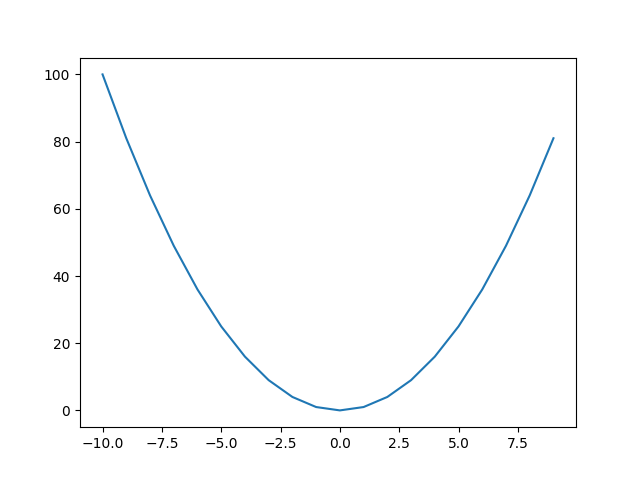

Coordinates recorded are: [(-8.042540322580646, 62.61904761904763)]
Coordinates recorded are: [(-8.042540322580646, 62.61904761904763), (-6.483467741935485, 42.380952380952394)]
Coordinates recorded are: [(-8.042540322580646, 62.61904761904763), (-6.483467741935485, 42.380952380952394), (-5.261491935483871, 32.26190476190477)]
Coordinates recorded are: [(-8.042540322580646, 62.61904761904763), (-6.483467741935485, 42.380952380952394), (-5.261491935483871, 32.26190476190477), (-3.7445564516129046, 9.047619047619051)]
Coordinates recorded are: [(-8.042540322580646, 62.61904761904763), (-6.483467741935485, 42.380952380952394), (-5.261491935483871, 32.26190476190477), (-3.7445564516129046, 9.047619047619051), (-3.7445564516129046, 10.23809523809524)]
Coordinates recorded are: [(-8.042540322580646, 62.61904761904763), (-6.483467741935485, 42.380952380952394), (-5.261491935483871, 32.26190476190477), (-3.7445564516129046, 9.047619047619051), (-3.7445564516129046, 10.23809523809524), (-3.7445

In [45]:

# to load the interactive plotting version
%matplotlib widget
reload(plotting)

coords = []

x = np.arange(-10,10)
y = x**2

plotting.onclick_coords([x,y])